In [1]:
from andreiNet.neural_net import NeuralNetwork
from andreiNet.losses import MSE
from andreiNet.utils import norm_data, one_hot_encode

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import time
import numpy as np
import matplotlib.pyplot as plt

In [3]:
boston = datasets.load_boston()

X = boston.data  
y = boston.target

X_trn, X_test, y_trn, y_test = train_test_split(X, 
                                                y, 
                                                test_size=0.5, 
                                                random_state=2)

print("X_trn.shape = {}, X_test.shape = {}".format(X_trn.shape, X_test.shape))
X_trn_norm, (trn_mean, trn_std) = norm_data(X_trn)
X_test_norm = (X_test - trn_mean) / trn_std

X_trn.shape = (253, 13), X_test.shape = (253, 13)


In [4]:
# Set parameters
activation = 'relu'
batch_size = 50
random_state = 0
lr = 0.001
n_epochs = 1000
loss = 'mse'
metrics = []
weight_init = 'he_norm'
hidden_layers = (100, )

# Initialize model
start_time = time.time()
nn = NeuralNetwork(hidden=hidden_layers, 
                   init_weights=weight_init,
                   loss = loss,
                   activation=activation,
                   shuffle=True,
                   random_state=random_state,
                   metrics=metrics,
                   verbose=False,
                   mode='regression'
                   )

# Train model
nn.train(X_trn_norm, y_trn, 
         n_epochs=n_epochs,
         batch_size=batch_size, 
         early_stop=None, #('accuracy', 100),
         lr=lr, 
         val_data=(X_test_norm, y_test),
         save_best=True)

# Run Inference
y_pred_trn = nn.predict(X_trn_norm).ravel()
y_pred_test = nn.predict(X_test_norm).ravel()
delta_1 = time.time() - start_time
print("--- %s seconds ---" % (delta_1))
print('trn MSE', MSE().loss(y_pred_trn, y_trn))
print('test MSE', MSE().loss(y_pred_test, y_test))

epoch 1000: final trn loss = 4.7296854503100905 trn metrics {'mse': 4.7296854503100905}
val metrics {'mse': 12.987164088899638}
setting best model from epoch 973
--- 2.4970619678497314 seconds ---
trn MSE 3.7372478765424217
test MSE 10.721296196782767


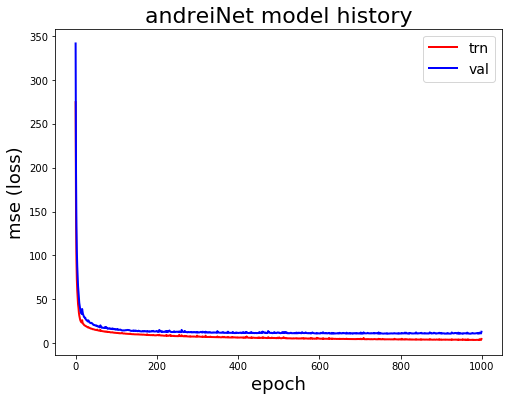

In [5]:
# Plot neural network history
fig_size = (8, 6)
plt.figure(figsize=fig_size)
x_axis = np.arange(len(nn.trn_metric_hist[loss]))
plt.plot(x_axis, nn.trn_metric_hist[loss], 
         c='r', linewidth=2, label='trn')
plt.plot(x_axis, nn.val_metric_hist[loss], 
         c='b', linewidth=2, label='val')
plt.xlabel('epoch', fontsize=18)
plt.ylabel(str(loss)+' (loss)', 
           fontsize=18)
plt.legend(prop={'size': 14})
plt.title('andreiNet model history', fontsize=22)
plt.show()

In [6]:
# Train Keras model
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
import tensorflow as tf
from tensorflow import set_random_seed
set_random_seed(random_state)
tf.logging.set_verbosity(tf.logging.ERROR)

np.random.seed(random_state)
start_time = time.time()

model = Sequential()
model.add(Dense(100, activation=activation, 
                input_dim=X_trn_norm.shape[1], 
                kernel_initializer='he_normal'))
model.add(Dense(1, activation='linear',))

sgd = SGD(lr=lr, decay=0.0, momentum=0.00, nesterov=False)

model.compile(loss='MSE',
              optimizer=sgd,
              metrics=[])
keras_hist = model.fit(X_trn_norm, y_trn,
                       epochs=n_epochs,
                       validation_data=(X_test_norm, y_test),
                       batch_size=batch_size,
                       verbose=0)

y_pred_trn_keras = model.predict(X_trn_norm).ravel()
y_pred_test_keras = model.predict(X_test_norm).ravel()
delta_2 = time.time() - start_time
del model
print("--- %s seconds ---" % (delta_2))
print('trn MSE', MSE().loss(y_pred_trn_keras, y_trn))
print('test MSE', MSE().loss(y_pred_test_keras, y_test))

Using TensorFlow backend.


--- 7.773184537887573 seconds ---
trn MSE 3.54692661123762
test MSE 11.829619039381667


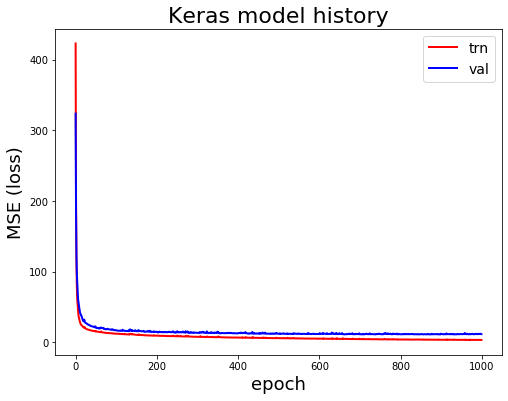

In [7]:
# Keras training history
fig_size = (8, 6)
x_axis = np.arange(n_epochs)
plt.figure(figsize=fig_size)

plt.plot(x_axis, keras_hist.history['loss'], 
         c='r', linewidth=2, label='trn')
plt.plot(x_axis, keras_hist.history['val_loss'], 
         c='b', linewidth=2, label='val')
plt.xlabel('epoch', fontsize=18)
plt.ylabel('MSE (loss)', fontsize=18)
plt.legend(prop={'size': 14})

plt.title('Keras model history', fontsize=22)
plt.show()

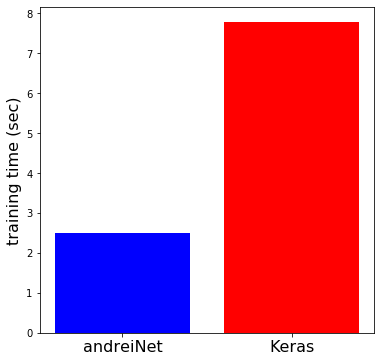

In [8]:
# compare training time
plt.figure(figsize=(6, 6))
trn_times = [delta_1, delta_2]
y_pos = [0, 1]
plt.bar(y_pos, trn_times, color=['blue', 'red'])
plt.xticks(y_pos, ['andreiNet', 'Keras'], fontsize=16) 
plt.ylabel('training time (sec)', fontsize=16)
plt.show()